In [1]:
import numpy as np
import matplotlib.pyplot as plt


from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import time

In [43]:
from scipy.ndimage import convolve

In [3]:
import sympy as sp

# Class

In [4]:
def metric_inversor(g):
    return None

In [5]:
class Numerical_warp_drive:
    def __init__(self, metric, t, x, y, z, inverse_metric=None):
        
        self.g = metric
        
       
        self.g_inv = inverse_metric

        if not(isinstance(g, np.ndarray)):
            if self.g_inv==None:
                self.g_inv=metric_inversor(self.g)
                

        self.t=t
        self.x=x
        self.y=y
        self.z=z


        #define physical quantities
        gravity_const=6.6743*1e-11
        c_speed_const=299792458
        pi_8=8*np.pi

        self.physical_energy_conversion=c_speed_const**4/pi_8/gravity_const
        self.physical_momentum_conversion=self.physical_energy_conversion/c_speed_const


    def compute_einstein_tensor(self,test_print=False):
        # Start the timer
        start_time = time.time()
        
   
        
        # Calculate the spacings between grid points in t, x, y, z
        dt = self.t[1] - self.t[0]  # spacing in t
        dx = self.x[1] - self.x[0]  # spacing in x
        dy = self.y[1] - self.y[0]  # spacing in y
        dz = self.z[1] - self.z[0]  # spacing in z
        
        # Derivatives of g with respect to each coordinate t, x, y, z
        #dg_dt, dg_dx, dg_dy, dg_dz = np.gradient(g, dt, dx, dy, dz, axis=(2, 3, 4, 5))
        dg = np.stack((np.gradient(self.g, dt, dx, dy, dz, axis=(2, 3, 4, 5))), axis=0)
        #the first index is the index of the derivative


        if test_print:
            print("==========================================================")
            print("dg")
            print(np.max(dg))
            print(np.min(dg))
            print(dg.shape)


        
            

        # Compute the Christoffel symbols (4, 4, 4, Nt, Nx, Ny, Nz) matrix
        A = np.zeros((4, 4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
        # Loop over all indices of the Christoffel symbol
        for mu in range(4):
            for nu in range(4):
                for rho in range(4):
                    
                    A[rho,mu,nu,:,:,:,:] = dg[mu,nu,rho,:,:,:,:] + dg[nu,mu,rho,:,:,:,:] - dg[rho,mu,nu,:,:,:,:]
                    
        Gamma = np.zeros((4, 4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
        
        
        for mu in range(4):
            for nu in range(4):
                for lam in range(4):
                    temp_sum=0
                    for rho in range(4):
                        temp_sum=temp_sum+g_inv[lam,rho,:,:,:,:]*A[rho,mu,nu,:,:,:,:]
                        
                        
                    Gamma[lam,mu,nu,:,:,:,:]=0.5*temp_sum
        
        del A
        del temp_sum

        self.Gamma=Gamma


        if test_print:
            print("==========================================================")
            print("Gamma")
            print(np.max(Gamma))
            print(np.min(Gamma))
            print(Gamma.shape)

        # Partial derivatives of Gamma with respect to each coordinate
        #dGamma_dt, dGamma_dx, dGamma_dy, dGamma_dz = np.gradient(Gamma, dt, dx, dy, dz, axis=(3, 4, 5, 6))
        dGamma = np.stack((np.gradient(Gamma, dt, dx, dy, dz, axis=(3, 4, 5, 6))), axis=0)


        if test_print:
            print("==========================================================")
            print("dGamma")
            print(np.max(dGamma))
            print(np.min(dGamma))
            print(dGamma.shape)



        # Initialize the Ricci tensor array (4, 4, T, N, M, K)
        Ricci = np.zeros((4, 4, Nt, Nx, Ny, Nz))
        
        for mu in range(4):
            for nu in range(4):
                term1=0 #Associated to uv
                term2=0 #Associated to uv
        
                term31=0 #Associated to u
                term32=0 #Associated to v
        
                term3=0 #Associated to uv
        
                term41_temp=np.zeros((4, 4, Nt, Nx, Ny, Nz)) #Associated to uv 
                for lam in range(4):
                    term1=term1+dGamma[lam,lam,mu,nu,:,:,:,:]
                    term2=term2+dGamma[nu,lam,mu,lam,:,:,:,:]
        
                    term31=term31+Gamma[lam,mu,lam,:,:,:,:]
                    term32=term32+Gamma[lam,nu,lam,:,:,:,:]
              
                    for rho in range(4):
                        term41_temp[lam,rho]=Gamma[lam,mu,rho,:,:,:,:]*Gamma[rho,nu,lam,:,:,:,:]
        
                term42_temp=np.zeros((4, Nt, Nx, Ny, Nz)) #Associated to uv 
                for lam in range(4):
                    term42_temp=term42_temp+term41_temp[lam,:,:,:,:,:]
        
                term4=0 #Associated to uv
                for rho in range(4):
                    term4=term4+term42_temp[rho,:,:,:,:]
        
        
                Ricci[mu,nu,:,:,:,:]=term1-term2+term3-term4

        
        
        del term1
        del term2
        del term31
        del term32
        del term3
        del term41_temp
        del term42_temp
        del term4
        del dGamma

        if test_print:
            print("==========================================================")
            print("Ricci")
            print(np.max(Ricci))
            print(np.min(Ricci))
            print(Ricci.shape)

        self.Ricci=Ricci


        R=0
        for mu in range(4):
            for nu in range(4):
                R=R+g_inv[mu,nu,:,:,:,:]*Ricci[mu,nu,:,:,:,:]
                
        
        G=Ricci-0.5*g*R

            
        if test_print:
            print("==========================================================")
            print("R")    
            print(np.max(R))
            print(np.min(R))
            print(R.shape)
            print("==========================================================")
            print("G")    
            print(np.max(G))
            print(np.min(G))
            print(G.shape)


        self.R=R
        self.G=G


        # End the timer
        end_time = time.time()
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        
        # Print the result and the elapsed time
        print(f"Time to compute the einstein tensor: {elapsed_time:.4f} seconds")


    def display_einstein_tensor(self):
        # Create a custom colormap (red-white-blue)
        cmap_rwb = LinearSegmentedColormap.from_list("rwb", ["red", "white", "blue"])
        
        # Define the index positions for slicing
        t_set = int(self.t.shape[0] / 2 + 0.5) - 1
        x_set = int(self.x.shape[0] / 2 + 0.5) - 1
        y_set = int(self.y.shape[0] / 2 + 0.5) - 1
        z_set = int(self.z.shape[0] / 2 + 0.5) - 1
    
        # Prepare the plot
        fig, axes = plt.subplots(4, 4, figsize=(16, 12))
        


        x1=self.x
        x2=self.y
        # Loop through and create heatmaps for each component
        for i in range(4):
            for j in range(4):
                F = self.G[i, j, t_set, :, :, z_set].T.astype(np.float64)*self.physical_energy_conversion
                

                #The following transformation allows to better see the variations of plot as sometimes it can be too faint 
                
                #F=np.sign(F)*np.log(np.abs(F)+1)
                #F=np.sign(F)*np.abs(F)**0.2
                
                ax = axes[i, j]
        
                # Determine the min and max values of the component
                min_F = np.min(F)
                max_F = np.max(F)
        
                # Determine the larger magnitude between min and max to set the colormap limits
                max_abs = max(abs(min_F), abs(max_F))
        
                # Plot with 'rwb' custom colormap centered around zero
                c = ax.contourf(x1, x2, F, levels=100, cmap=cmap_rwb, vmin=-max_abs, vmax=max_abs)
                ax.set_title(f'$T_{{{i}{j}}}$')
                ax.set_xlabel('x1 [m]')
                ax.set_ylabel('x2 [m]')
                
                # Add colorbar with the same limits for every subplot
                fig.colorbar(c, ax=ax, label=r'Energy Density $[ \mathrm{J \, m^{-3}} ]$')
        
        plt.tight_layout()
        plt.show()
            

                
        

        

   

# Workflow

## Alcubierre Metric

### Define the metric

In [6]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = f**2 * v**2 - 1
g[0, 1] = -f * v
g[1, 0] = -f * v
g[1, 1] = 1
g[2, 2] = 1
g[3, 3] = 1

### Define the inverse metric

In [7]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1
g_inv[0, 1] = -f * v
g_inv[1, 0] = -f * v
g_inv[1, 1] = 1 - f**2 * v**2
g_inv[2, 2] = 1
g_inv[3, 3] = 1



### Define the warp drive and compute 

In [8]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [9]:
warp_test.compute_einstein_tensor(test_print=True)

dg
0.0007284613
-0.0007284613
(4, 4, 4, 51, 51, 51, 51)
Gamma
0.0007284613
-0.0007284613
(4, 4, 4, 51, 51, 51, 51)
dGamma
7.739638e-06
-7.739638e-06
(4, 4, 4, 4, 51, 51, 51, 51)
Ricci
3.359699808164196e-06
-5.002679346777228e-06
(4, 4, 51, 51, 51, 51)
R
1.2649664805058753e-06
-9.894550928302233e-07
(51, 51, 51, 51)
G
3.3621159209221945e-06
-4.993213126937925e-06
(4, 4, 51, 51, 51, 51)
Time to compute the einstein tensor: 39.9768 seconds


updated!


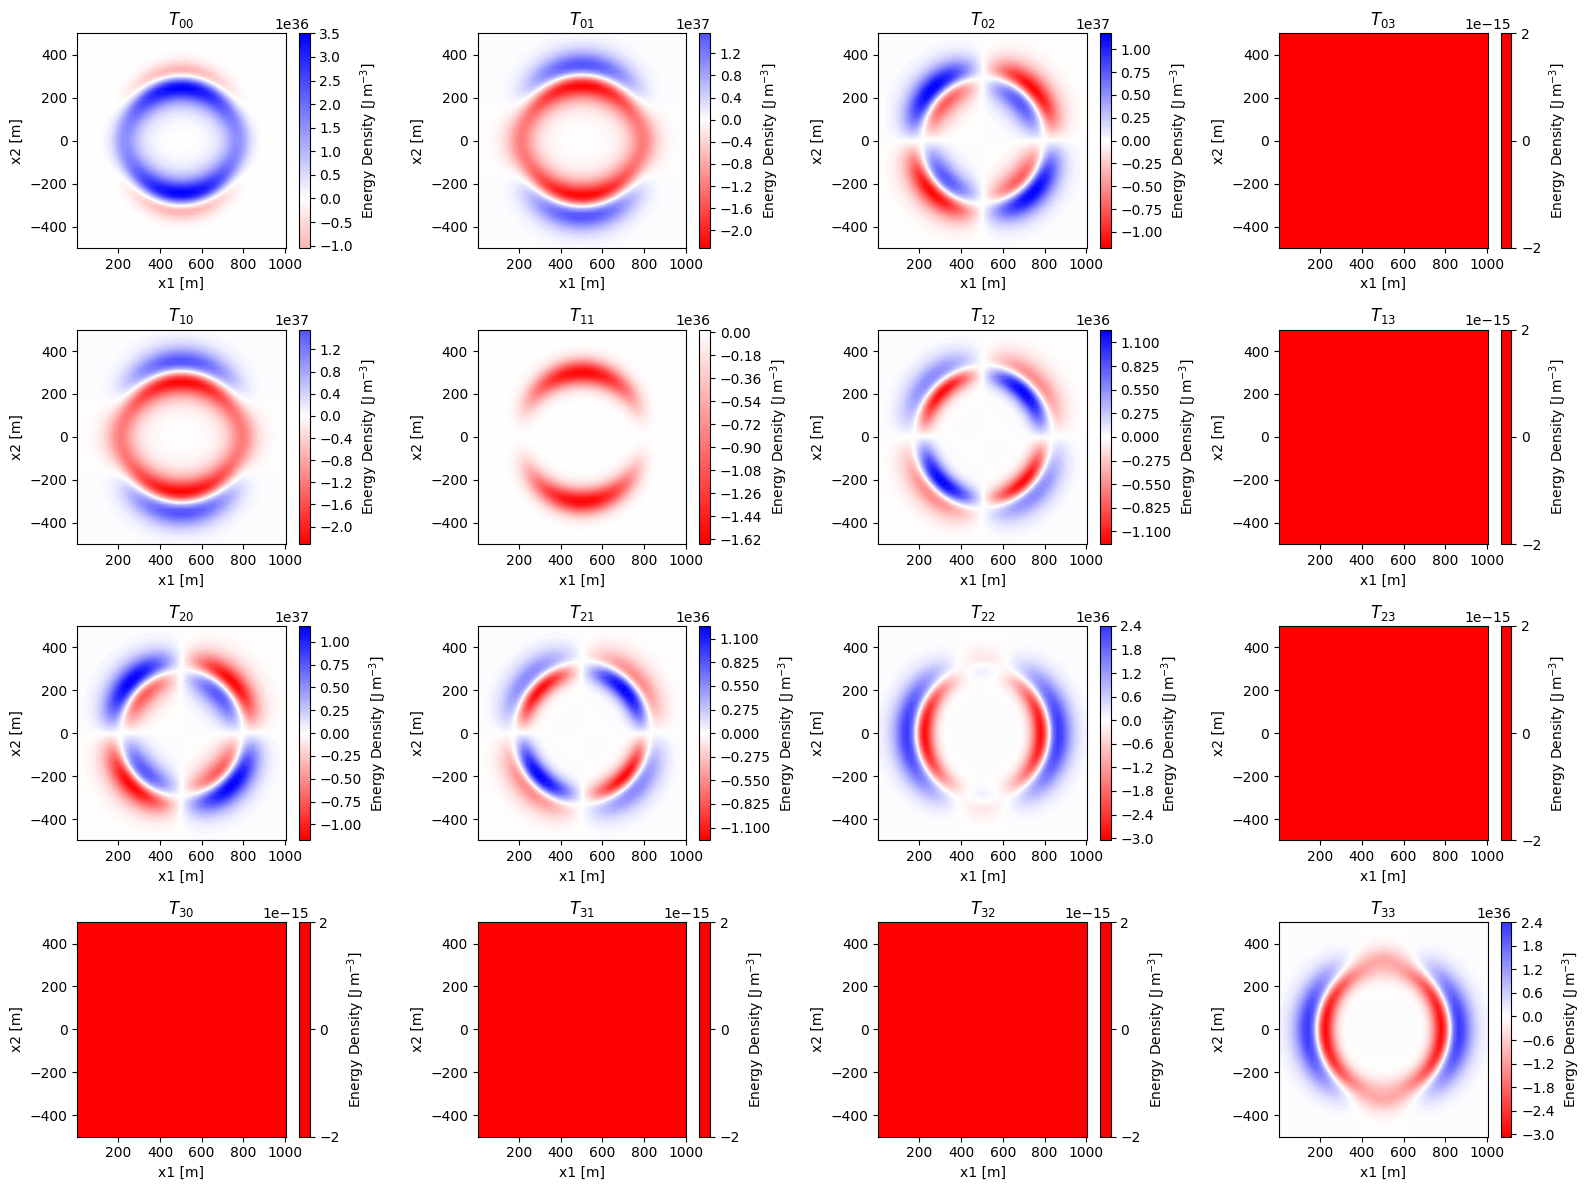

In [10]:
warp_test.display_einstein_tensor()

## Van Den Broeck Metric

### Define the metric

In [6]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015*4)

N=71

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))



sigma2=np.float32(0.015*4)
R_tilde=np.float32(200)
alpha=np.float32(0.5)
    
B =1 + alpha*(np.tanh(sigma2 * (r + R_tilde)) - np.tanh(sigma2 * (r - R_tilde))) / (2 * np.tanh(sigma2 * R_tilde))
  

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = f**2 * v**2 * B**2 - 1
g[0, 1] = -f * v * B**2
g[1, 0] = -f * v * B**2
g[1, 1] = B**2
g[2, 2] = B**2
g[3, 3] = B**2

### Define the inverse metric

In [7]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1
g_inv[0, 1] = -f * v
g_inv[1, 0] = -f * v
g_inv[1, 1] = 1/B**2 - f**2 * v**2
g_inv[2, 2] = 1/B**2
g_inv[3, 3] = 1/B**2

### Define the warp drive and compute

In [8]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [9]:
warp_test.compute_einstein_tensor()

Time to compute the einstein tensor: 385.7124 seconds


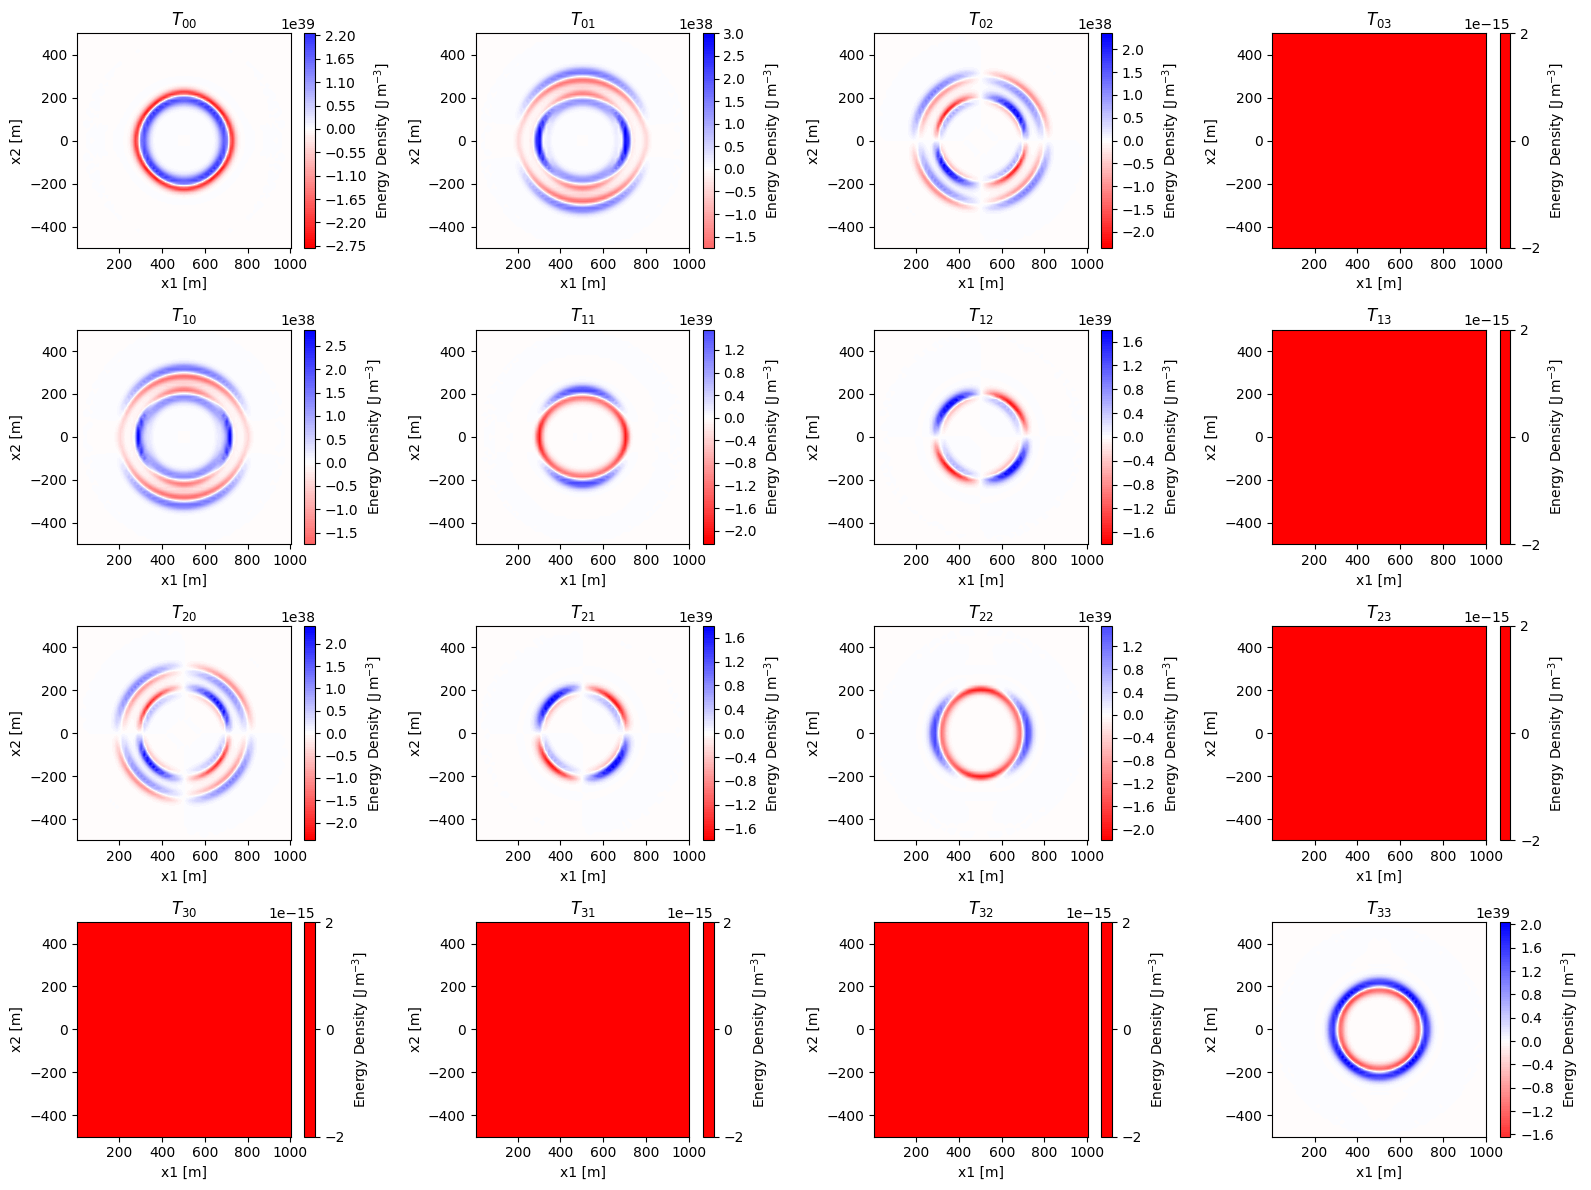

In [10]:
warp_test.display_einstein_tensor()

## Bobrick-Martire Modified Time Metric

### Define the metric

In [49]:
# Define parameters directly as float16
v, R, sigma = np.float32(0.1), np.float32(300), np.float32(0.015*4)

N=51

# Define the size of the grid
Nt, Nx, Ny, Nz = N,N,N,N

# Create meshgrid for t, x, y, z with dtype specified once
t = np.linspace(-500, 500, Nt, dtype=np.float32) + 503 / v
x = np.linspace(-500, 500, Nx, dtype=np.float32) + 503
y = np.linspace(-500, 500, Ny, dtype=np.float32)
z = np.linspace(-500, 500, Nz, dtype=np.float32)

# Create meshgrid in float16
t_mesh, x_mesh, y_mesh, z_mesh = np.meshgrid(t, x, y, z, indexing='ij')

# Calculate r in float32 and convert to float16 at the end
r = np.sqrt((x_mesh - v * t_mesh).astype(np.float32) ** 2 +
            y_mesh.astype(np.float32) ** 2 +
            z_mesh.astype(np.float32) ** 2).astype(np.float32)

# Calculate f directly as float16
f = (np.tanh(sigma * (r + R)) - np.tanh(sigma * (r - R))) / (2 * np.tanh(sigma * R))


A=np.where(r < R, 0.5, 1)
# Define a smoothing kernel (averaging filter)
kernel = np.ones((5, 5, 5)) / 125


for t_ind in range(Nt):
    A[t_ind]=convolve(A[t_ind], kernel, mode='constant', cval=1)


  

# Initialize the metric tensor g as float16 and populate it
g = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)
g[0, 0] = -((1-f)+(f*A))**2+(f*v)**2
g[0, 1] = -f * v 
g[1, 0] = -f * v 
g[1, 1] = 1
g[2, 2] = 1
g[3, 3] = 1

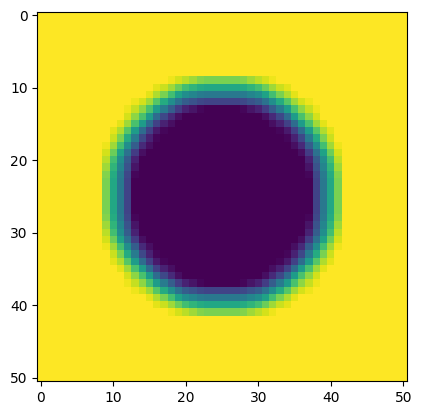

In [50]:
plt.imshow(A[25,:,:,25])

### Define the inverse metric

In [51]:
# Initialize the metric tensor g
g_inv = np.zeros((4, 4, Nt, Nx, Ny, Nz), dtype=np.float32)

# Populate the metric tensor g according to the given relationships
g_inv[0, 0] = -1/(((1-f)+(f*A))**2)
g_inv[0, 1] = -f * v/(((1-f)+(f*A))**2)
g_inv[1, 0] = -f * v/(((1-f)+(f*A))**2)
g_inv[1, 1] = 1-(f*v)**2/(((1-f)+(f*A))**2)
g_inv[2, 2] = 1
g_inv[3, 3] = 1

### Define the warp drive and compute

In [52]:
warp_test=Numerical_warp_drive(g,t,x,y,z,g_inv)

In [53]:
warp_test.compute_einstein_tensor()

Time to compute the einstein tensor: 42.3546 seconds


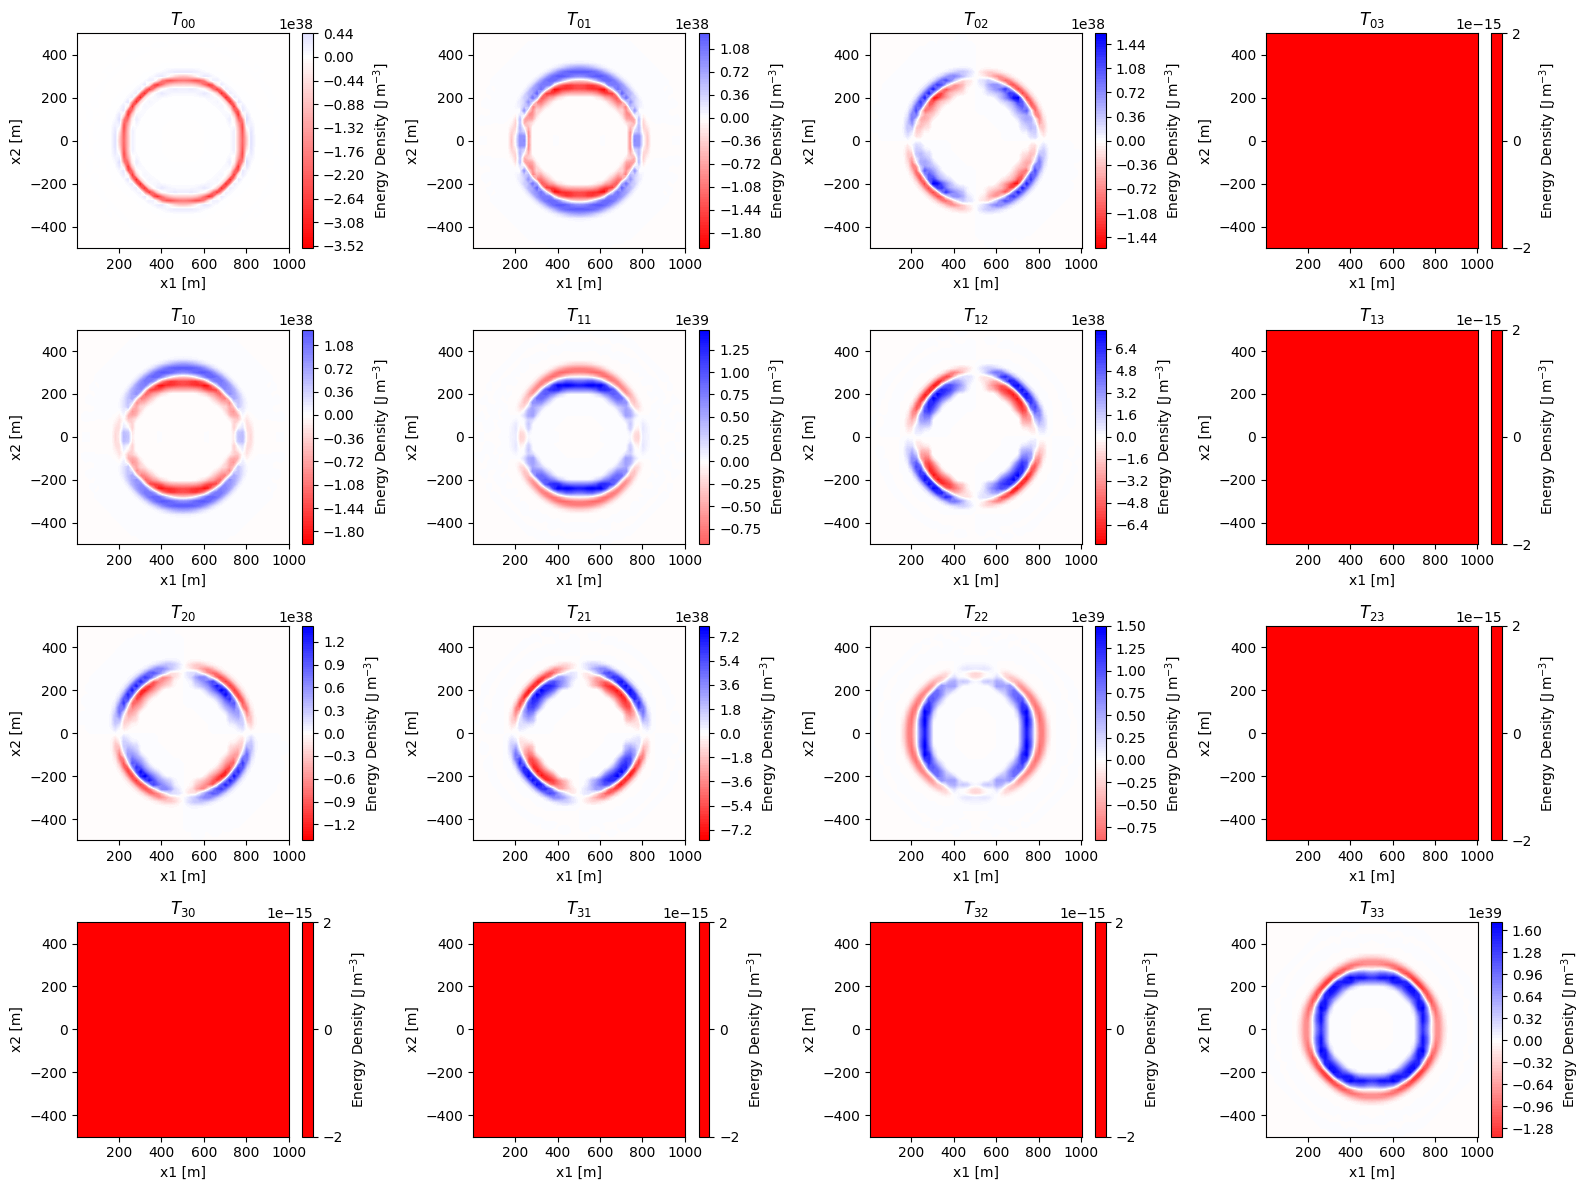

In [54]:
warp_test.display_einstein_tensor()